In [1]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-03-17 08:22:13.626340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 08:22:13.626405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 08:22:13.626413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


### Load and process data

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [5]:
data = pd.read_pickle('../data/data_proton_photonsum_70_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_70_2312_0_3360.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (40853, 56, 30) max: 765.0
Loaded cond:  (40853, 12) max: 7000.0 min: -7000.0


In [6]:
# calculate min max proton sum
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()

In [7]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Pdg', 'Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 10)

In [8]:
data_cond.head()

Pdg    Energy   Vx   Vy   Vz        Px        Py        Pz        mass  \
0  2212  3961.550  0.0  0.0  0.0 -0.076487  0.179845  3961.550  938.272081   
1  2212  2778.400  0.0  0.0  0.0 -0.102053  0.152853  2778.400  938.272081   
2  2212  3195.120  0.0  0.0  0.0  0.560528 -0.149980  3195.110  938.272081   
3  -211   613.734  0.0  0.0  0.0  1.178260 -0.828276  -613.733  139.570610   
4  2212  3045.430  0.0  0.0  0.0 -0.449678  0.101160  3045.430  938.272081   

   charge  
0     1.0  
1     1.0  
2     1.0  
3    -1.0  
4     1.0

In [9]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "vae"

EXPERIMENT_DIR_NAME = f"{NAME}_{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  vae_70_2312_17_03_2023_08_22


In [10]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [11]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [12]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

data max 6.641182 min 0.0
cond max 8.353683 min -7.9837365


In [13]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32682, 56, 30) (8171, 56, 30) (32682, 10) (8171, 10)


In [14]:
# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

### Define Model

In [15]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond,x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_1[0][0]']               
                                                                                            

In [16]:
#trainin params

EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1, 56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

In [17]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss
        # total_loss = reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss

In [18]:
filepath_mod = f"../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
history_loss = []
def train(dataset, epochs):
    tf_step = tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # Save the model every epoch
        encoder.compile()
        generator.compile()
        encoder.save(os.path.join(filepath_mod, "enc_"+NAME + "_"+ str(epoch) +".h5"))
        generator.save(os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5"))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),
                 np.array(history))
        calculate_ws_ch(min(epoch//5+1, 5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


filepath_img = f"../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

def generate_and_save_images(model, epoch, test_input):
    
    SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

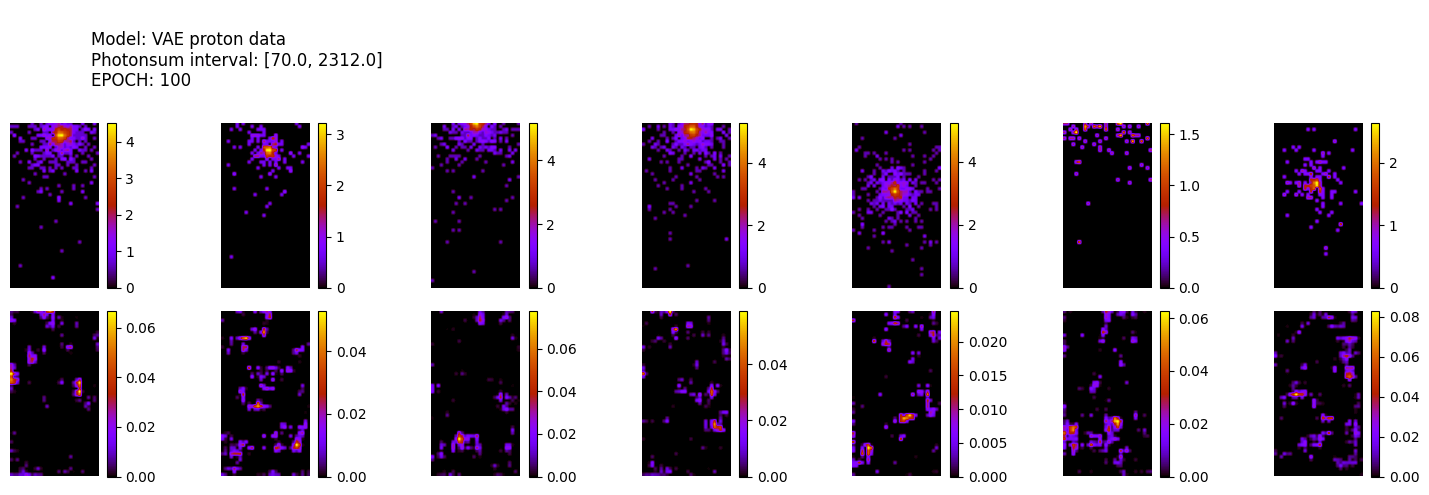

100 [Total loss: 143.94] [Recon_loss: 135.43] [KL loss: 12.16]
200 [Total loss: 128.59] [Recon_loss: 120.34] [KL loss: 11.79]


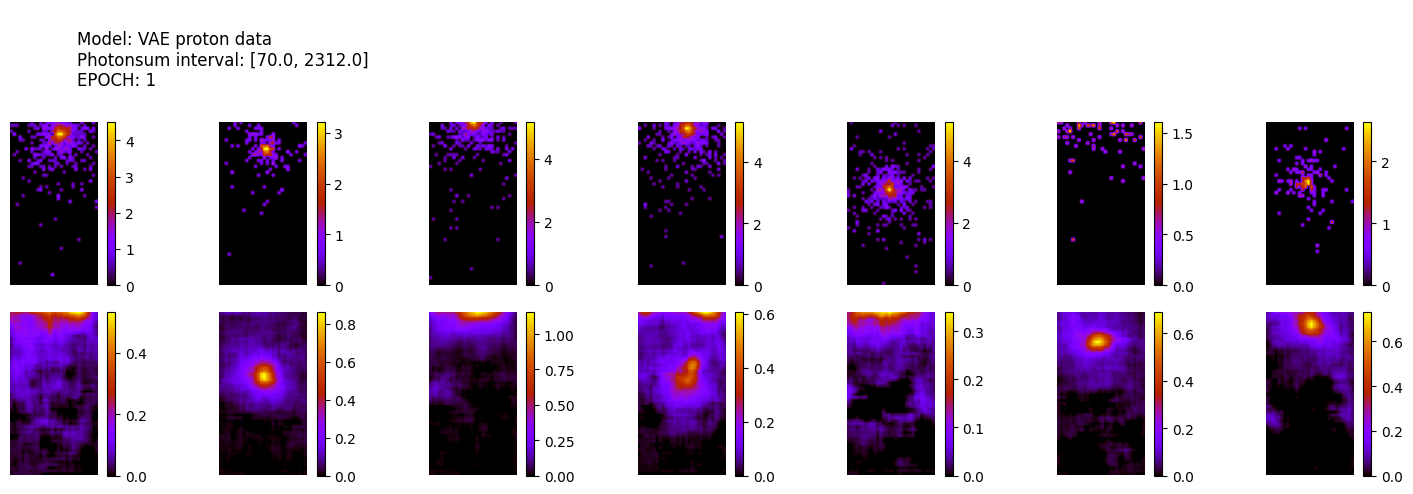

256/256 [==============================] - 1s 4ms/step
ws mean 103.16 ch1 0.12 ch2 86.02 ch3 0.68 ch4 172.20 ch5 256.79 Time for epoch 1 is 20.850414752960205 sec
300 [Total loss: 107.22] [Recon_loss: 99.35] [KL loss: 11.24]
400 [Total loss: 113.89] [Recon_loss: 106.39] [KL loss: 10.72]
500 [Total loss: 113.15] [Recon_loss: 105.94] [KL loss: 10.30]


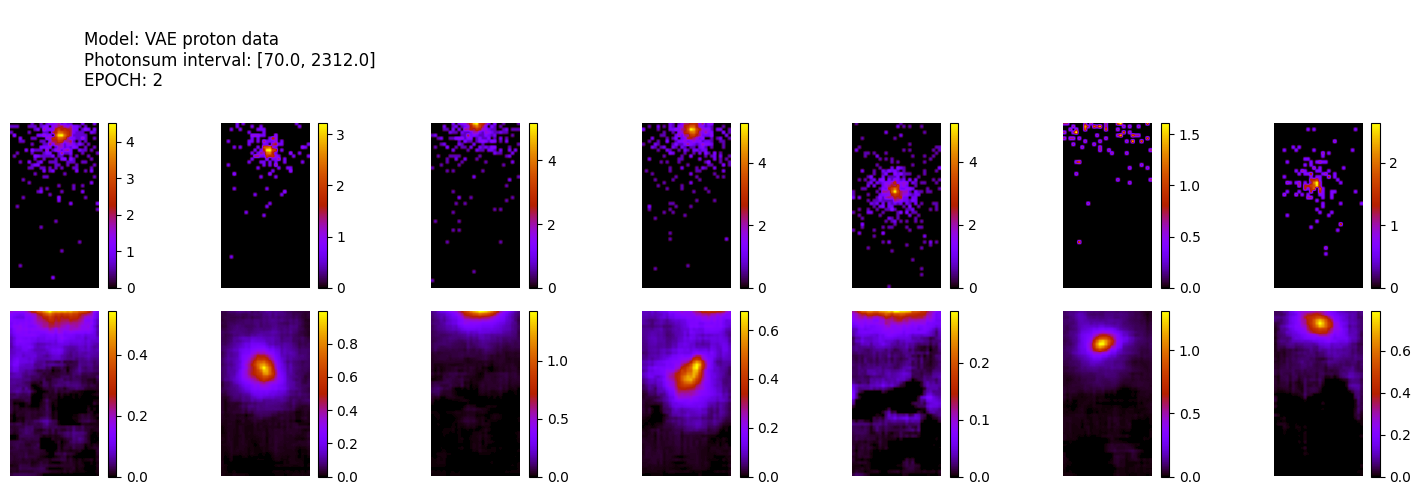

256/256 [==============================] - 1s 4ms/step
ws mean 99.10 ch1 0.12 ch2 81.65 ch3 0.65 ch4 166.78 ch5 246.28 Time for epoch 2 is 15.301926851272583 sec
600 [Total loss: 101.68] [Recon_loss: 95.26] [KL loss: 9.18]
700 [Total loss: 103.30] [Recon_loss: 97.45] [KL loss: 8.35]


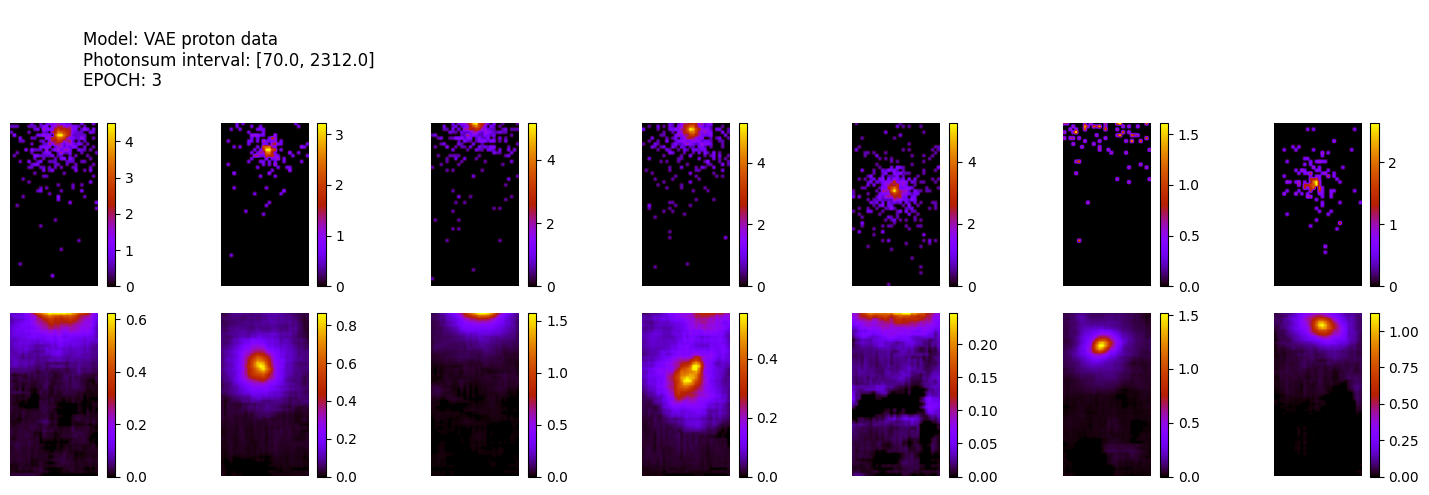

256/256 [==============================] - 1s 4ms/step
ws mean 95.20 ch1 0.08 ch2 79.21 ch3 0.67 ch4 159.44 ch5 236.61 Time for epoch 3 is 15.19690752029419 sec
800 [Total loss: 111.91] [Recon_loss: 105.34] [KL loss: 9.39]
900 [Total loss: 101.03] [Recon_loss: 95.02] [KL loss: 8.58]
1000 [Total loss: 109.56] [Recon_loss: 103.75] [KL loss: 8.29]


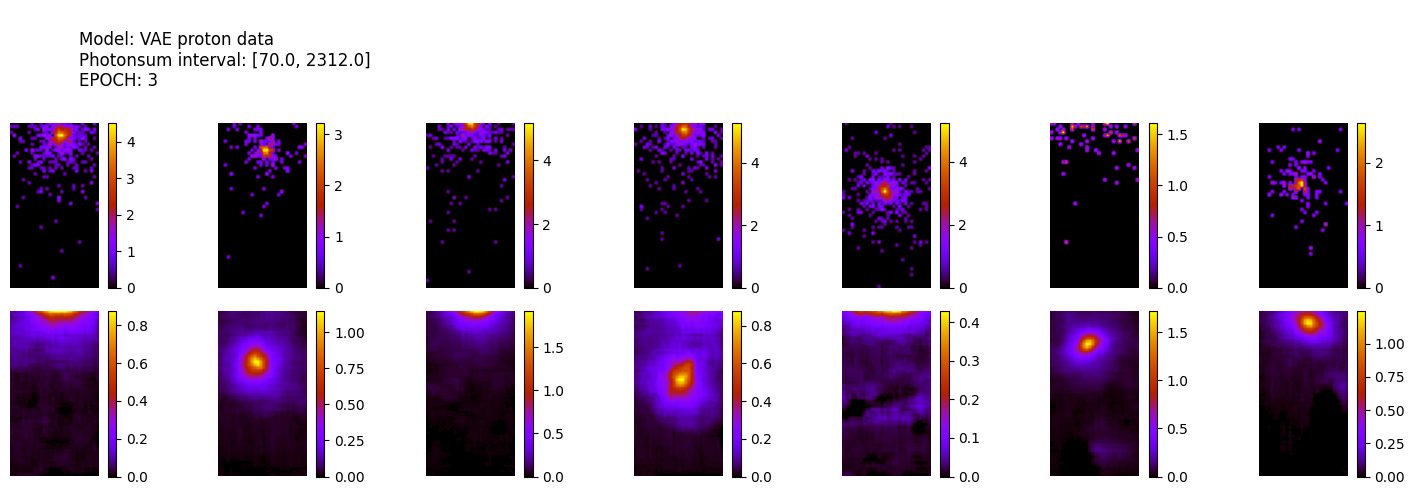

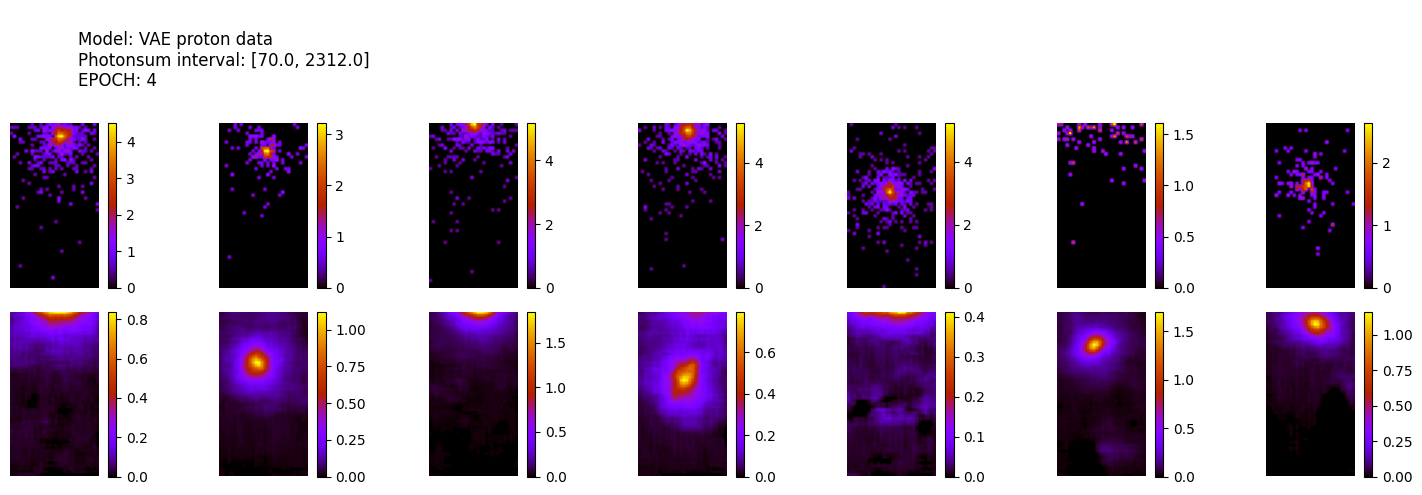

256/256 [==============================] - 1s 4ms/step
ws mean 87.32 ch1 0.10 ch2 73.82 ch3 0.50 ch4 145.65 ch5 216.55 Time for epoch 4 is 17.329635858535767 sec
1100 [Total loss: 96.87] [Recon_loss: 91.16] [KL loss: 8.16]
1200 [Total loss: 107.03] [Recon_loss: 101.42] [KL loss: 8.01]


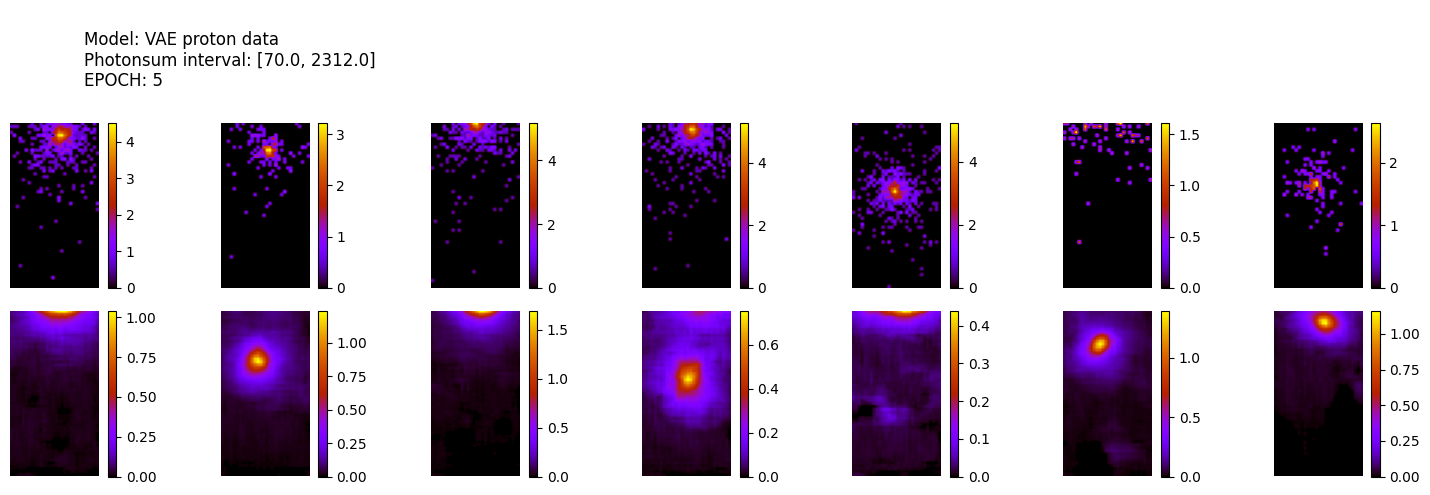

256/256 [==============================] - 1s 4ms/step
ws mean 91.59 ch1 0.12 ch2 76.42 ch3 0.65 ch4 153.02 ch5 227.72 Time for epoch 5 is 15.199229717254639 sec
1300 [Total loss: 106.49] [Recon_loss: 100.43] [KL loss: 8.66]
1400 [Total loss: 106.27] [Recon_loss: 100.48] [KL loss: 8.26]
1500 [Total loss: 106.62] [Recon_loss: 101.34] [KL loss: 7.54]


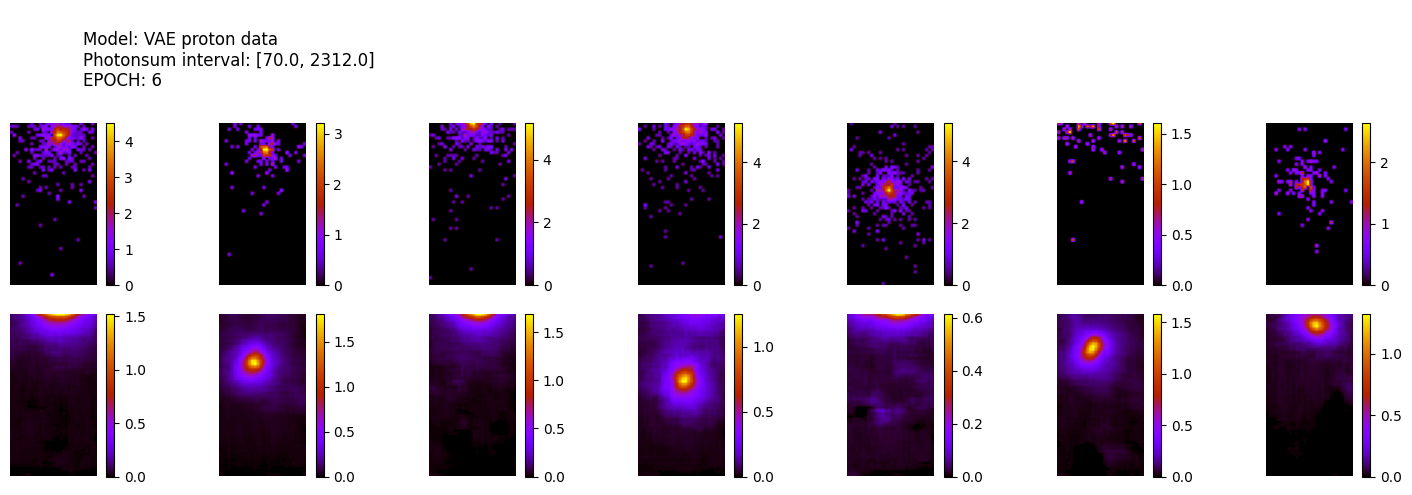

256/256 [==============================] - 1s 4ms/step
ws mean 81.62 ch1 0.08 ch2 68.51 ch3 0.55 ch4 136.62 ch5 202.36 Time for epoch 6 is 17.55202031135559 sec
1600 [Total loss: 99.93] [Recon_loss: 94.57] [KL loss: 7.66]
1700 [Total loss: 96.46] [Recon_loss: 91.07] [KL loss: 7.70]


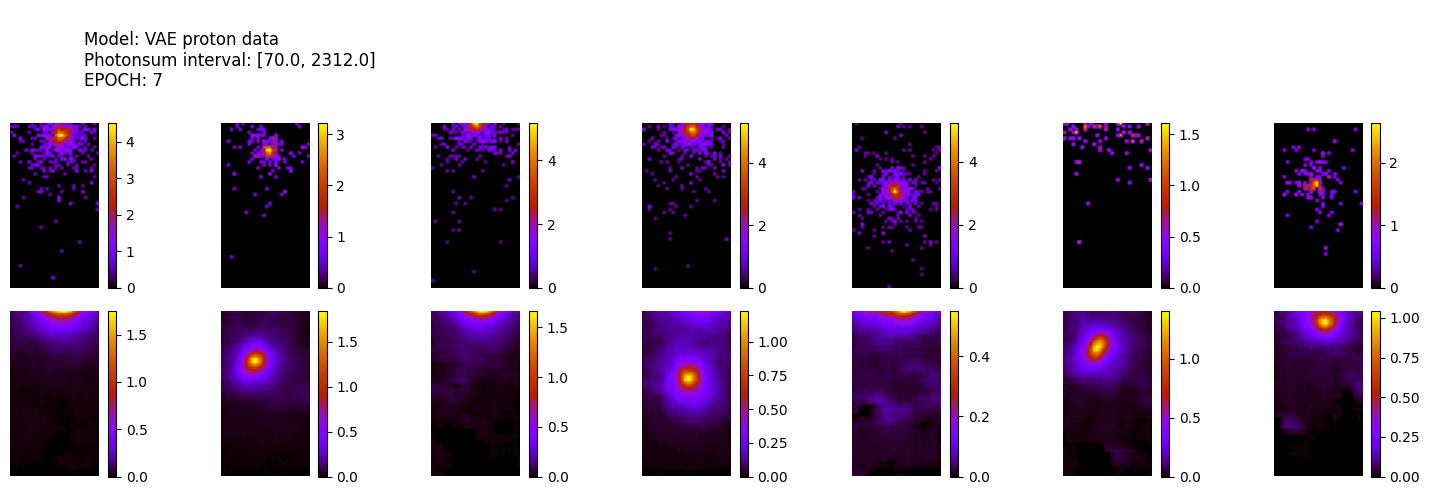

256/256 [==============================] - 1s 4ms/step
ws mean 82.65 ch1 0.10 ch2 68.52 ch3 0.56 ch4 139.02 ch5 205.04 Time for epoch 7 is 17.598456859588623 sec
1800 [Total loss: 92.88] [Recon_loss: 88.00] [KL loss: 6.98]
1900 [Total loss: 104.25] [Recon_loss: 99.27] [KL loss: 7.11]
2000 [Total loss: 95.69] [Recon_loss: 90.66] [KL loss: 7.19]


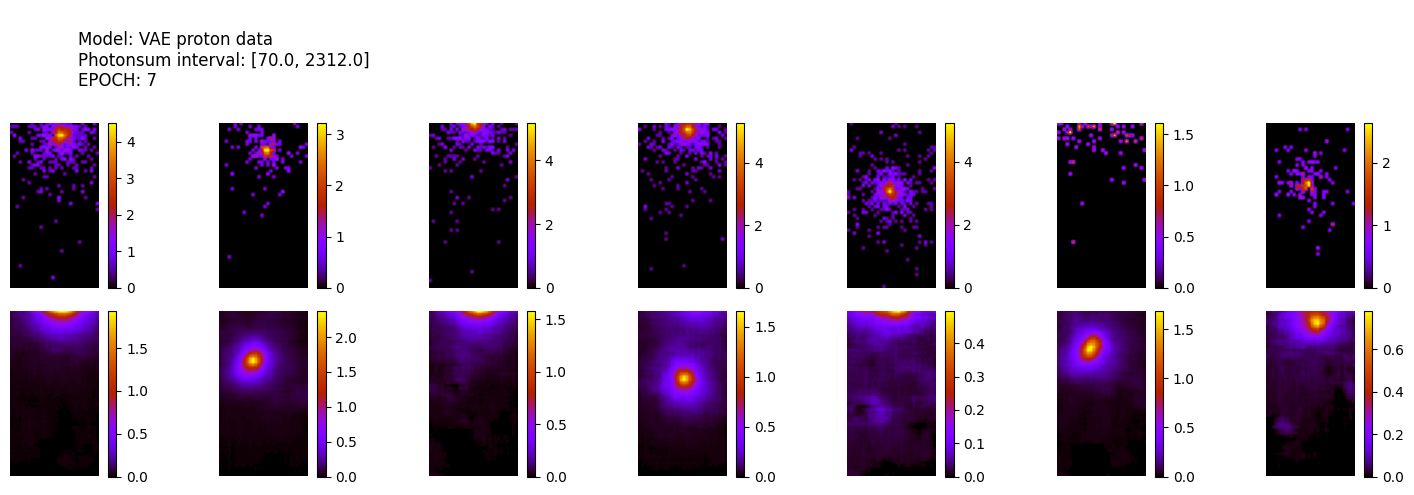

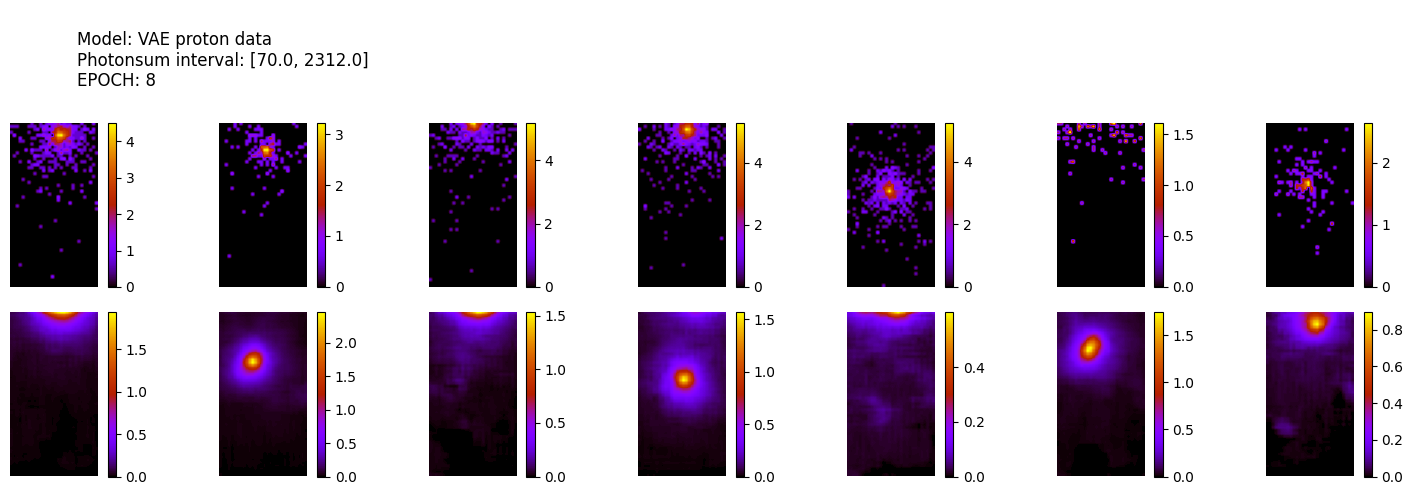

256/256 [==============================] - 1s 4ms/step
ws mean 77.03 ch1 0.08 ch2 62.92 ch3 0.48 ch4 130.67 ch5 190.98 Time for epoch 8 is 19.15607523918152 sec
2100 [Total loss: 102.06] [Recon_loss: 96.73] [KL loss: 7.63]
2200 [Total loss: 104.90] [Recon_loss: 100.02] [KL loss: 6.97]
2300 [Total loss: 103.31] [Recon_loss: 98.51] [KL loss: 6.87]


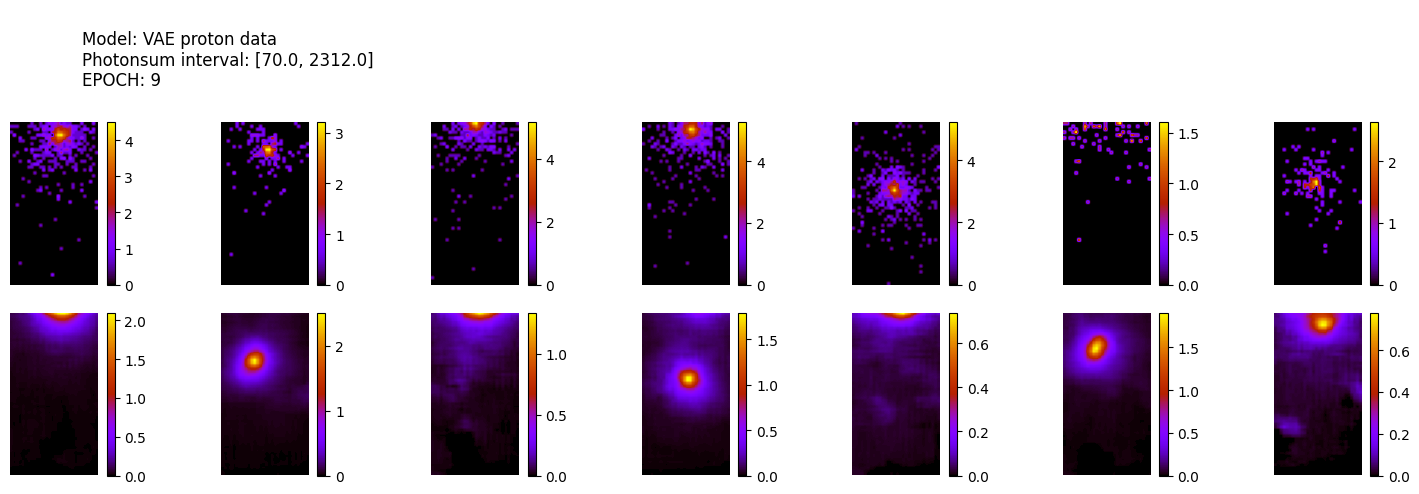

256/256 [==============================] - 1s 4ms/step
ws mean 75.06 ch1 0.10 ch2 62.17 ch3 0.54 ch4 126.89 ch5 185.63 Time for epoch 9 is 17.385742902755737 sec
2400 [Total loss: 95.53] [Recon_loss: 90.58] [KL loss: 7.07]
2500 [Total loss: 97.93] [Recon_loss: 93.41] [KL loss: 6.46]


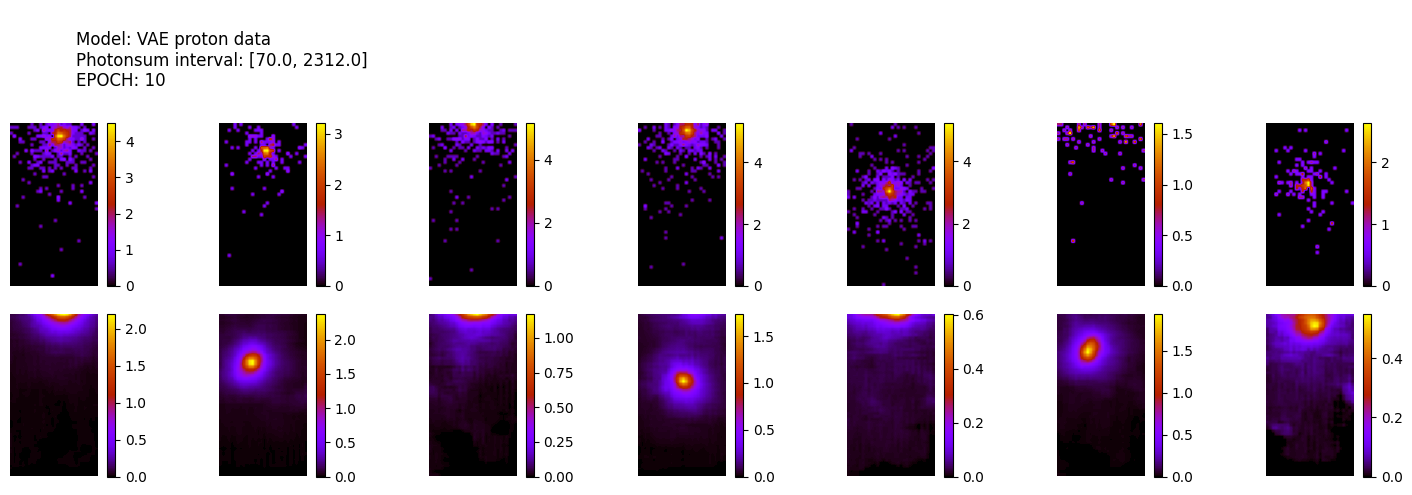

256/256 [==============================] - 1s 4ms/step
ws mean 81.66 ch1 0.08 ch2 69.35 ch3 0.56 ch4 135.32 ch5 202.97 Time for epoch 10 is 17.785369634628296 sec
2600 [Total loss: 98.97] [Recon_loss: 94.20] [KL loss: 6.82]
2700 [Total loss: 98.96] [Recon_loss: 94.08] [KL loss: 6.97]
2800 [Total loss: 102.32] [Recon_loss: 97.47] [KL loss: 6.93]


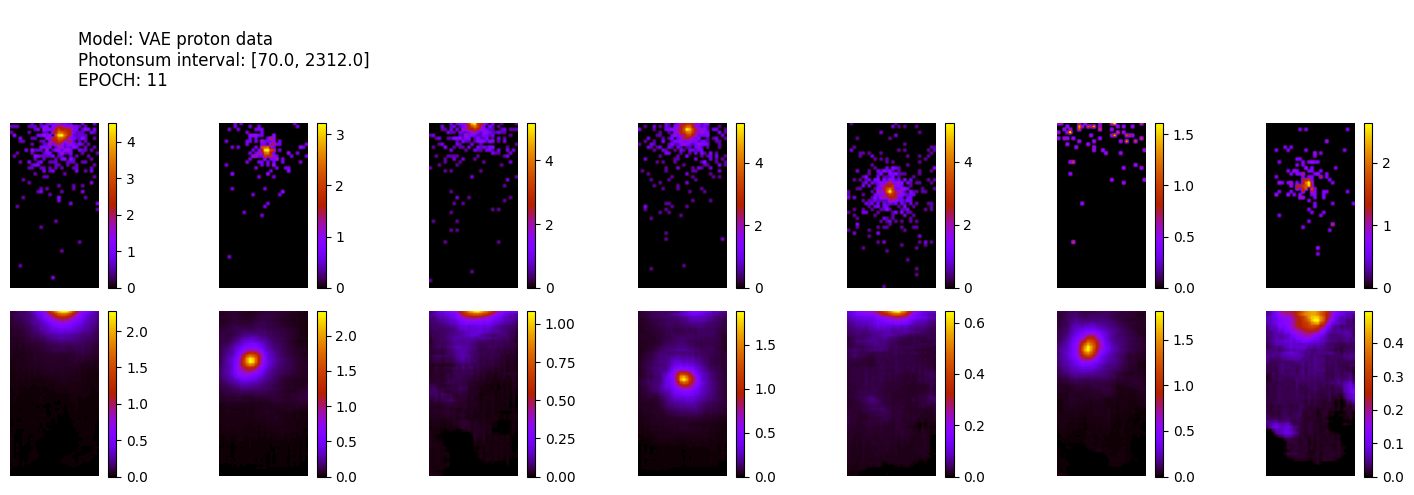

256/256 [==============================] - 1s 4ms/step
ws mean 84.53 ch1 0.08 ch2 70.55 ch3 0.57 ch4 141.35 ch5 210.09 Time for epoch 11 is 19.795390605926514 sec
2900 [Total loss: 99.71] [Recon_loss: 94.79] [KL loss: 7.03]
3000 [Total loss: 100.59] [Recon_loss: 96.16] [KL loss: 6.34]


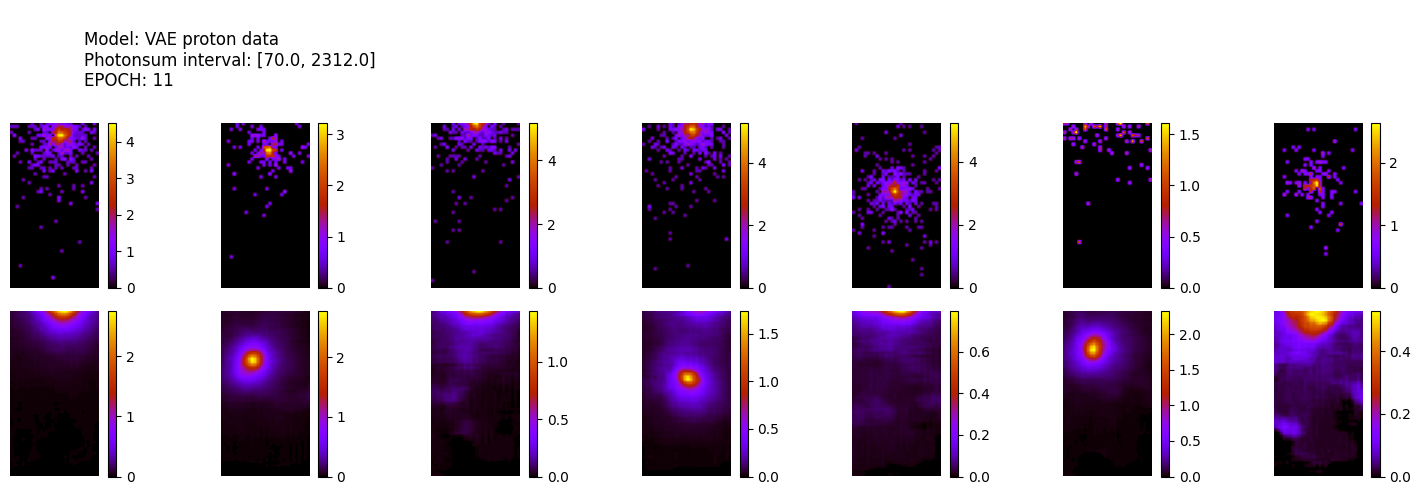

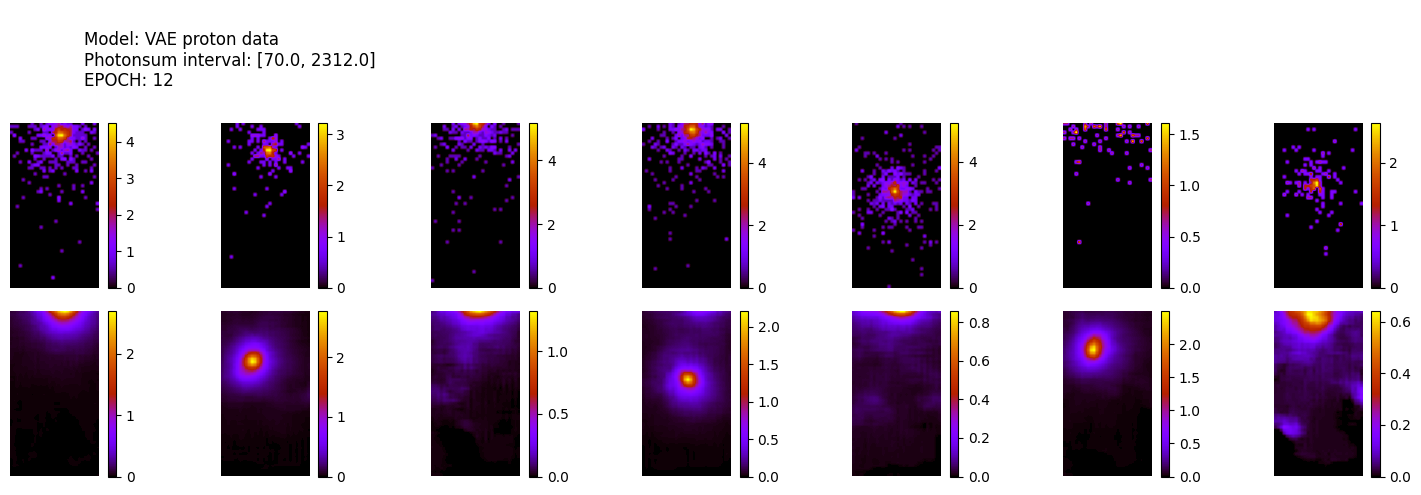

256/256 [==============================] - 1s 4ms/step
ws mean 71.60 ch1 0.08 ch2 59.17 ch3 0.53 ch4 120.74 ch5 177.50 Time for epoch 12 is 21.38355278968811 sec
3100 [Total loss: 97.83] [Recon_loss: 93.52] [KL loss: 6.16]
3200 [Total loss: 107.02] [Recon_loss: 102.05] [KL loss: 7.10]
3300 [Total loss: 105.66] [Recon_loss: 101.05] [KL loss: 6.59]


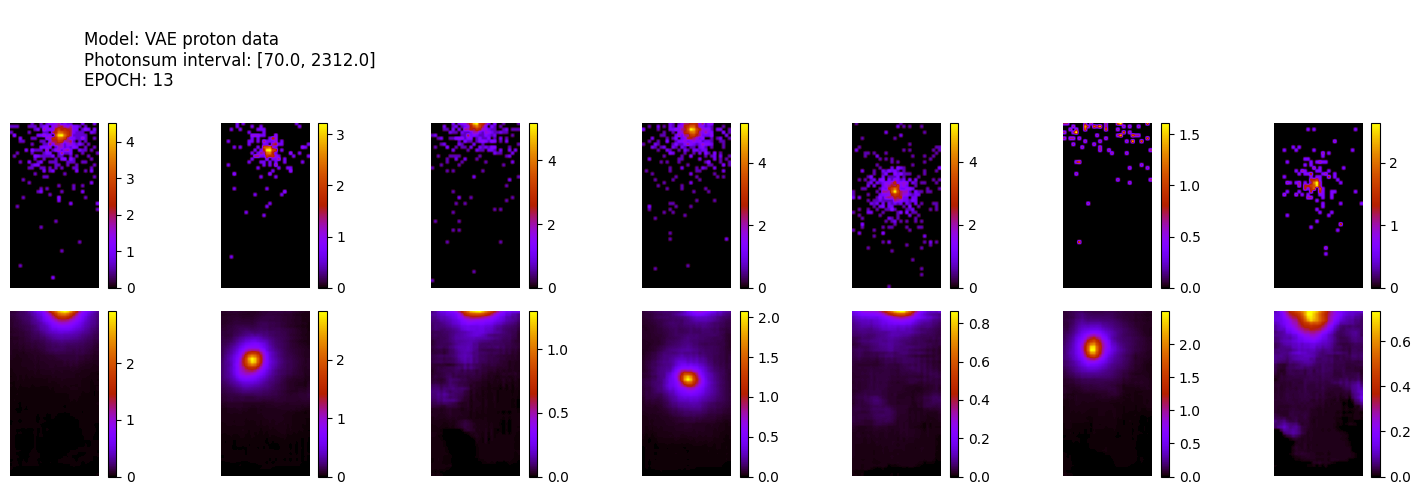

256/256 [==============================] - 1s 4ms/step
ws mean 68.34 ch1 0.09 ch2 56.29 ch3 0.48 ch4 116.02 ch5 168.81 Time for epoch 13 is 19.79429864883423 sec
3400 [Total loss: 100.60] [Recon_loss: 95.80] [KL loss: 6.86]
3500 [Total loss: 104.55] [Recon_loss: 99.97] [KL loss: 6.55]


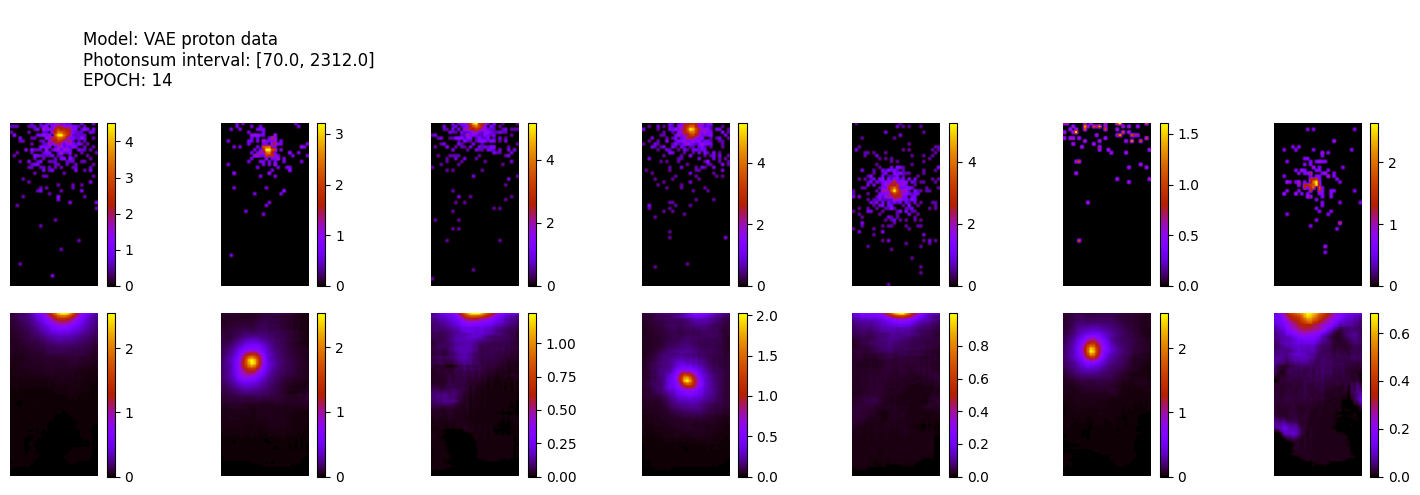

256/256 [==============================] - 1s 4ms/step
ws mean 77.97 ch1 0.10 ch2 65.70 ch3 0.52 ch4 129.93 ch5 193.62 Time for epoch 14 is 19.59750270843506 sec
3600 [Total loss: 99.94] [Recon_loss: 95.41] [KL loss: 6.48]
3700 [Total loss: 97.10] [Recon_loss: 92.80] [KL loss: 6.14]
3800 [Total loss: 95.41] [Recon_loss: 91.24] [KL loss: 5.97]


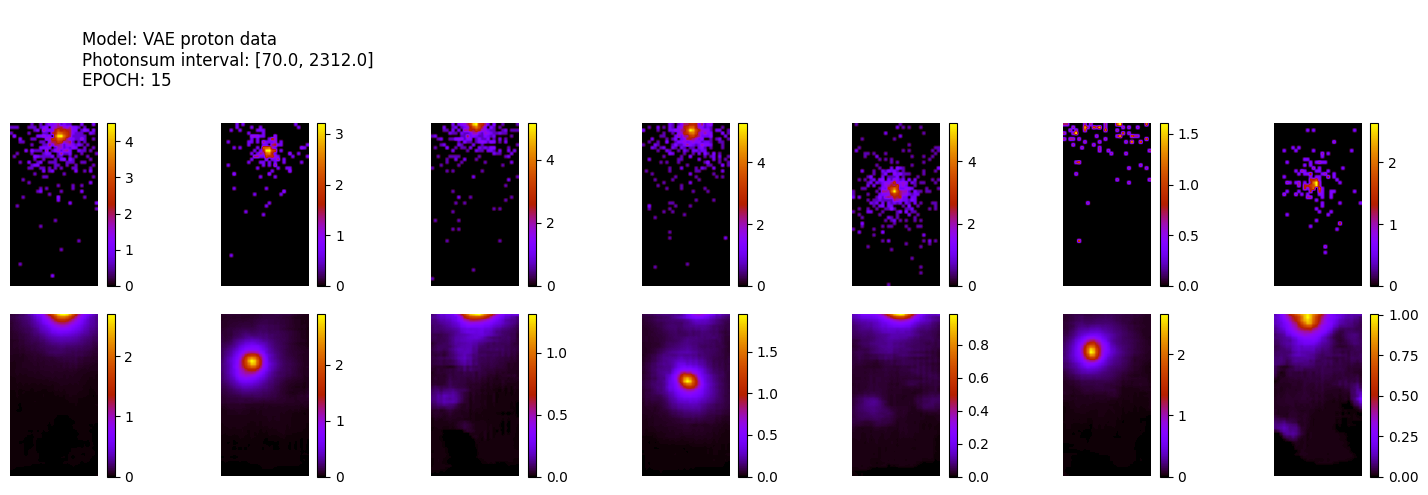

256/256 [==============================] - 1s 4ms/step
ws mean 66.68 ch1 0.08 ch2 55.18 ch3 0.49 ch4 113.38 ch5 164.28 Time for epoch 15 is 19.754782676696777 sec
3900 [Total loss: 104.25] [Recon_loss: 99.96] [KL loss: 6.13]
4000 [Total loss: 98.12] [Recon_loss: 93.64] [KL loss: 6.40]


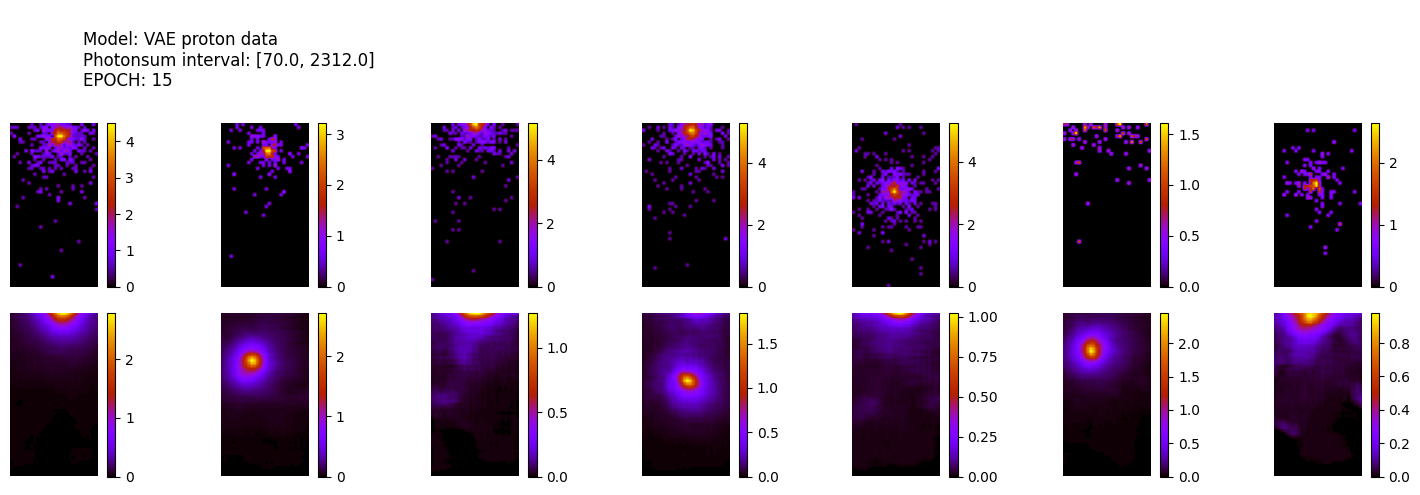

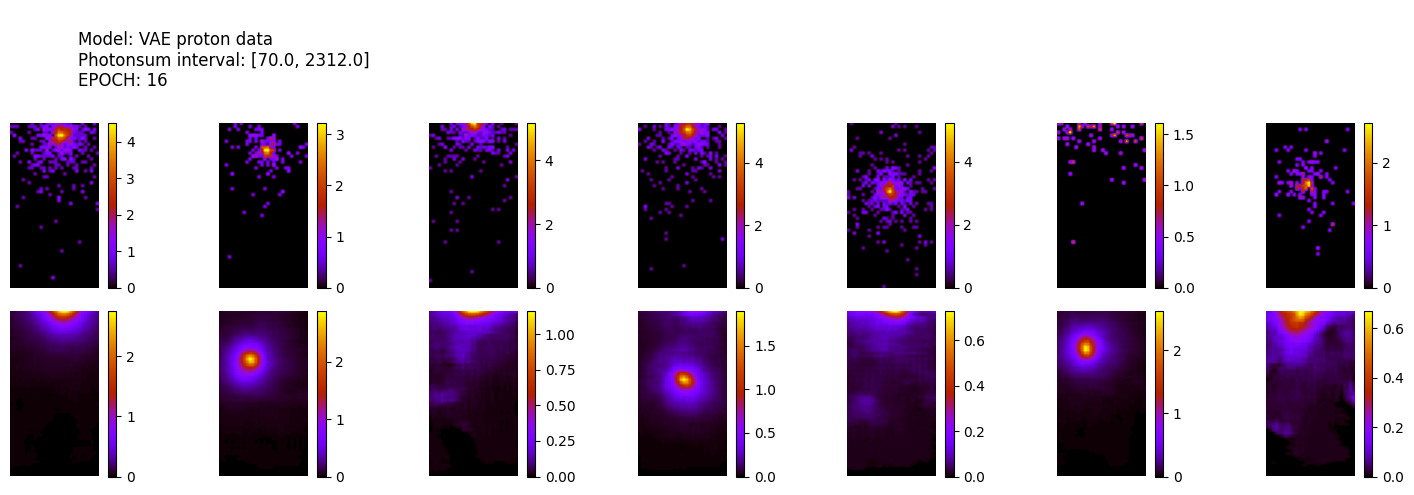

256/256 [==============================] - 1s 4ms/step
ws mean 70.99 ch1 0.09 ch2 60.03 ch3 0.50 ch4 118.39 ch5 175.91 Time for epoch 16 is 23.53597640991211 sec
4100 [Total loss: 103.64] [Recon_loss: 99.40] [KL loss: 6.07]
4200 [Total loss: 108.18] [Recon_loss: 103.33] [KL loss: 6.94]
4300 [Total loss: 95.59] [Recon_loss: 91.45] [KL loss: 5.92]


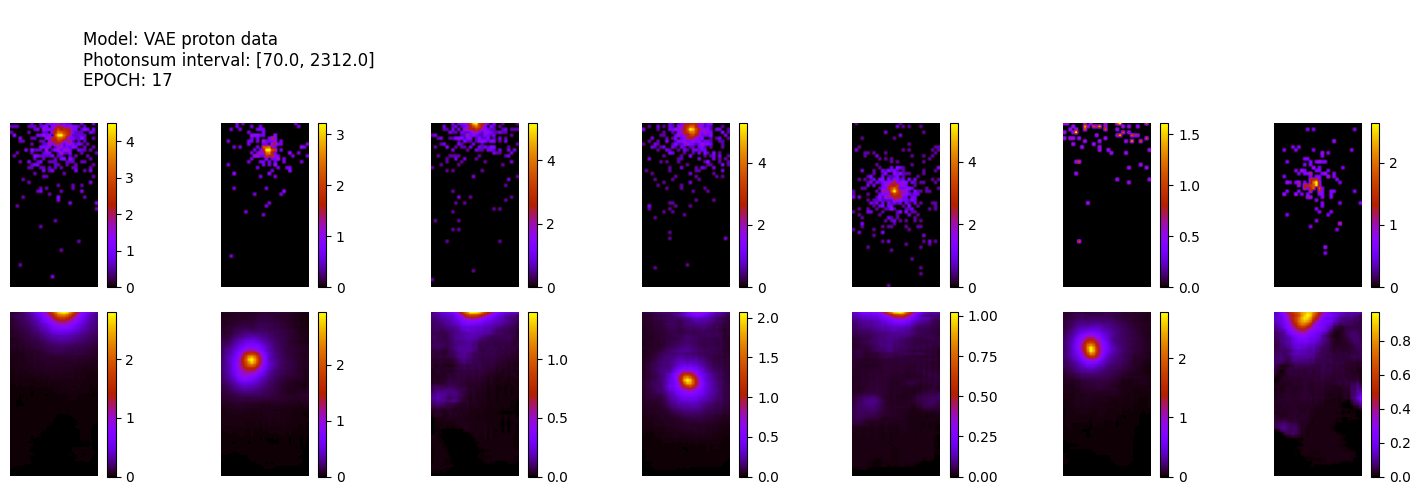

256/256 [==============================] - 1s 4ms/step
ws mean 67.52 ch1 0.09 ch2 56.82 ch3 0.47 ch4 112.93 ch5 167.30 Time for epoch 17 is 21.951464414596558 sec
4400 [Total loss: 98.73] [Recon_loss: 94.42] [KL loss: 6.17]
4500 [Total loss: 100.18] [Recon_loss: 95.84] [KL loss: 6.19]
4600 [Total loss: 96.75] [Recon_loss: 92.45] [KL loss: 6.15]


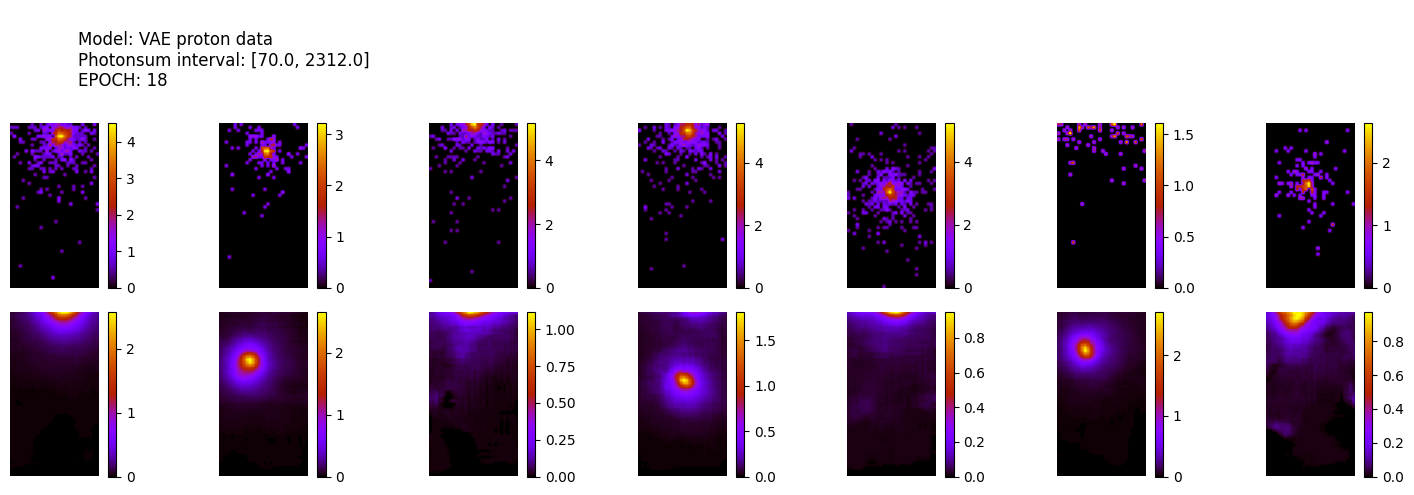

256/256 [==============================] - 1s 4ms/step
ws mean 76.66 ch1 0.07 ch2 64.21 ch3 0.48 ch4 127.79 ch5 190.78 Time for epoch 18 is 21.94883966445923 sec
4700 [Total loss: 100.03] [Recon_loss: 95.43] [KL loss: 6.56]
4800 [Total loss: 100.95] [Recon_loss: 96.47] [KL loss: 6.41]


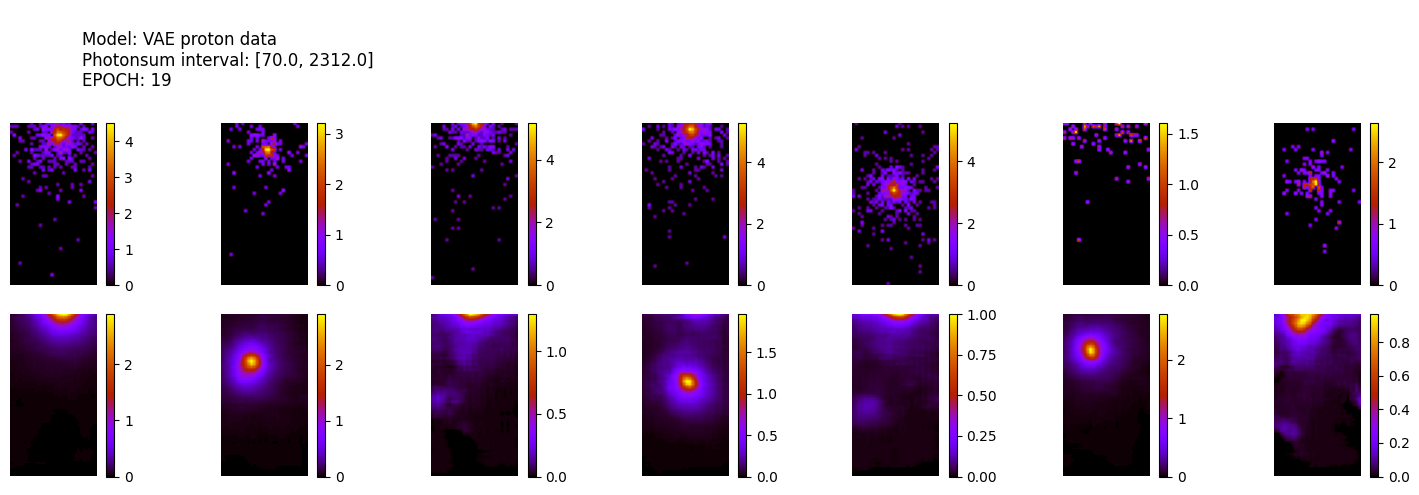

256/256 [==============================] - 1s 4ms/step
ws mean 66.85 ch1 0.09 ch2 54.75 ch3 0.43 ch4 113.63 ch5 165.36 Time for epoch 19 is 21.94275975227356 sec
4900 [Total loss: 101.72] [Recon_loss: 97.40] [KL loss: 6.18]
5000 [Total loss: 102.04] [Recon_loss: 98.07] [KL loss: 5.68]


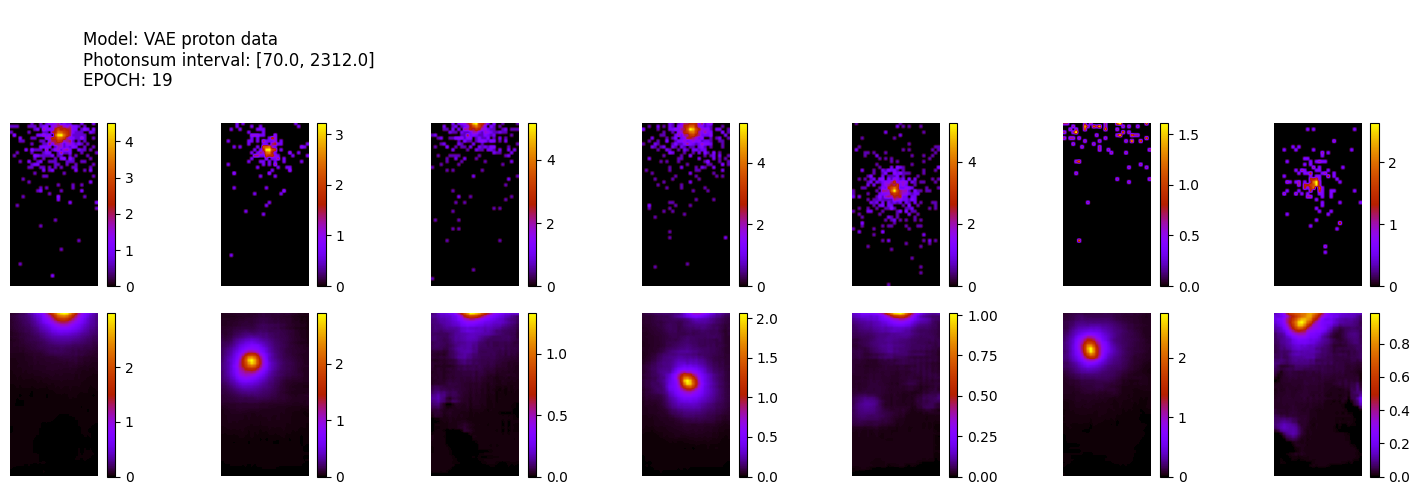

5100 [Total loss: 106.10] [Recon_loss: 101.43] [KL loss: 6.67]


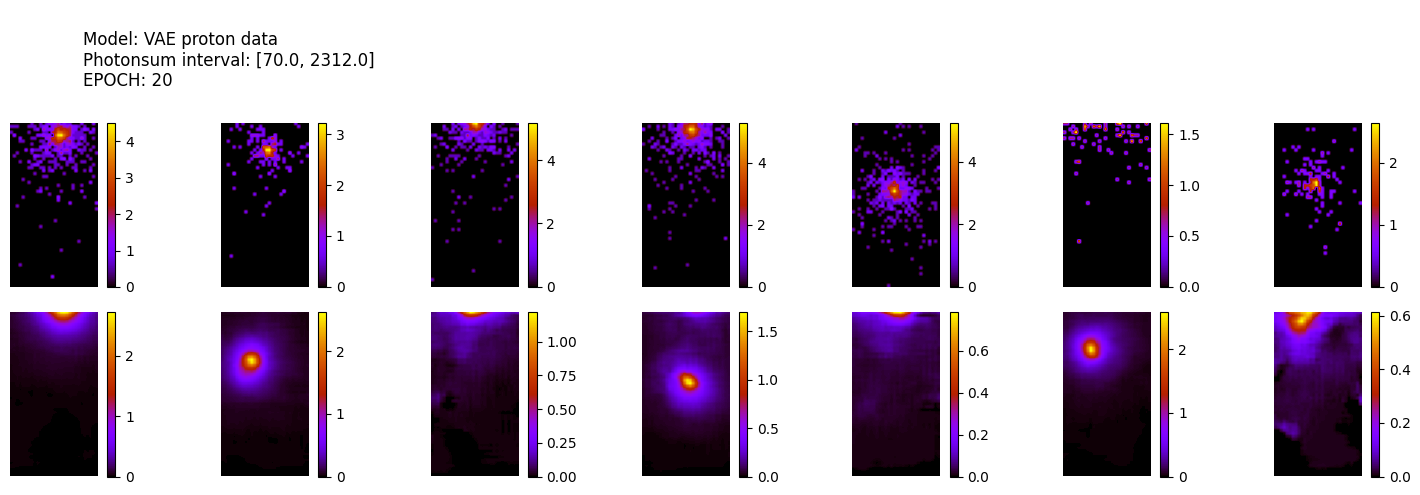

256/256 [==============================] - 1s 4ms/step
ws mean 76.46 ch1 0.08 ch2 65.84 ch3 0.54 ch4 125.49 ch5 190.32 Time for epoch 20 is 23.43457579612732 sec
5200 [Total loss: 92.13] [Recon_loss: 88.12] [KL loss: 5.74]
5300 [Total loss: 99.09] [Recon_loss: 94.84] [KL loss: 6.06]


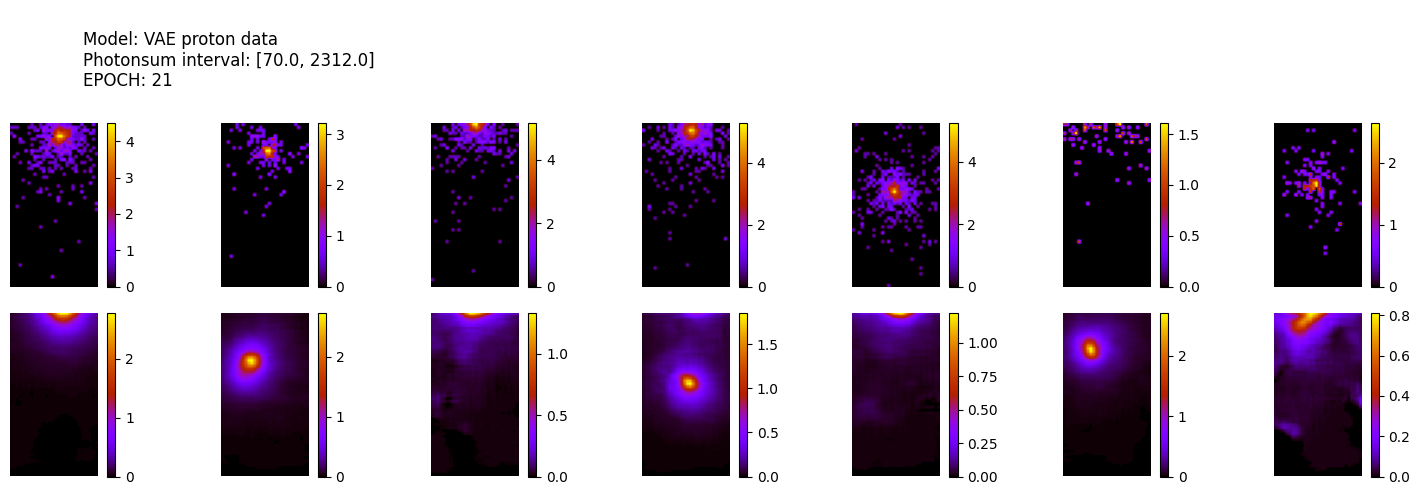

209/256 [=======================>......] - ETA: 0s

In [ ]:
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [ ]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [ ]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [ ]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [ ]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(f"../images/proton_photonsum_30/{loss_str}_loss")

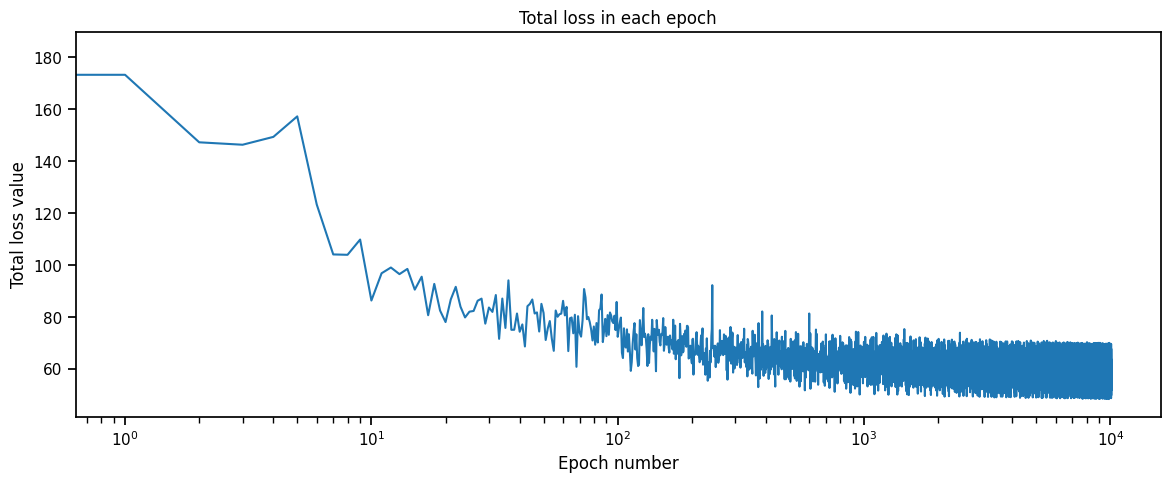

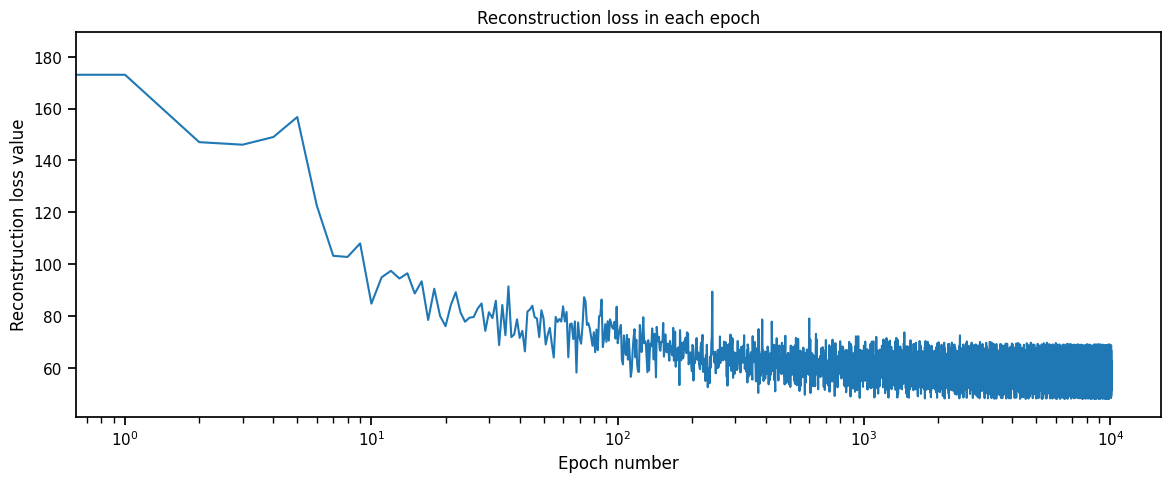

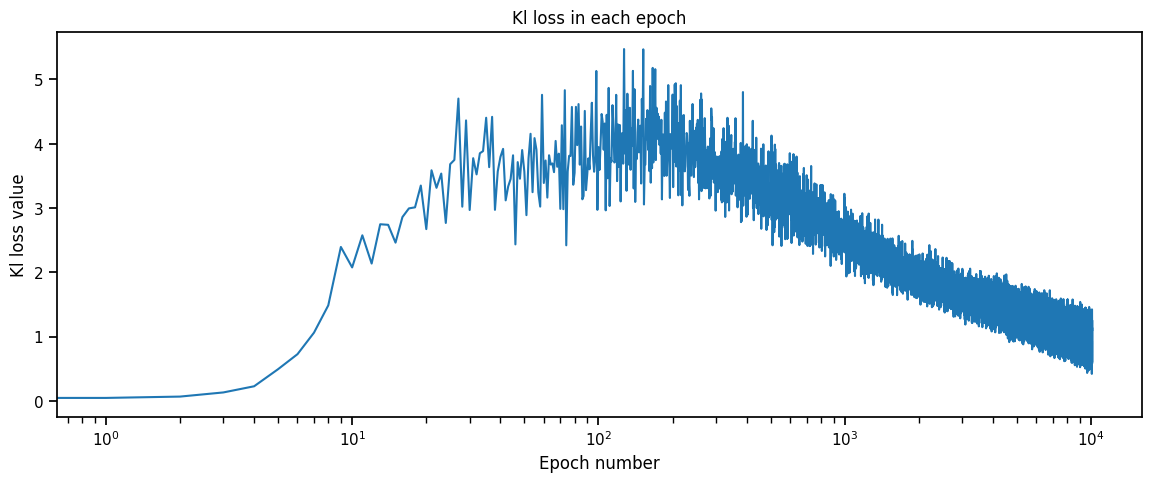

In [44]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")

In [105]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [106]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [112]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")

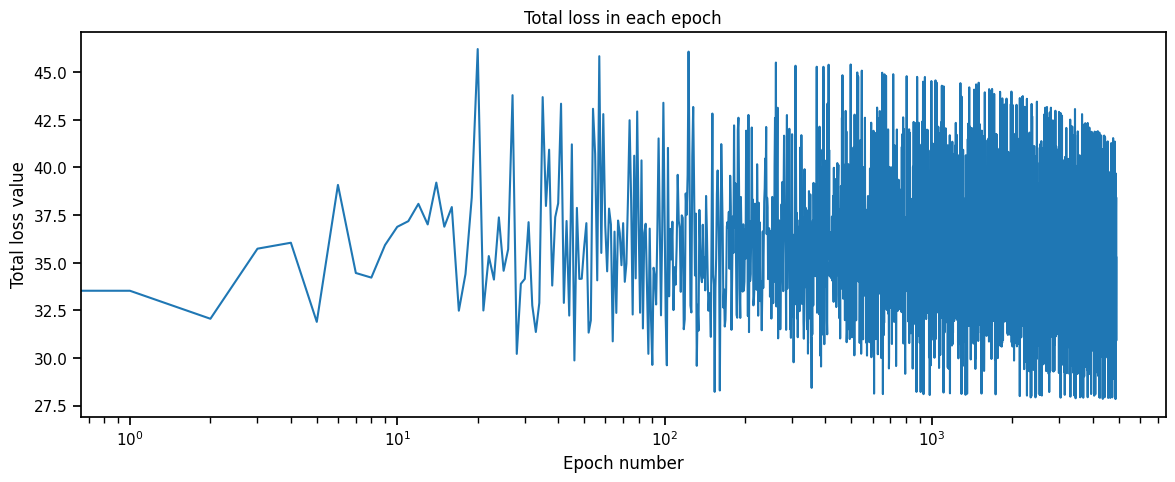

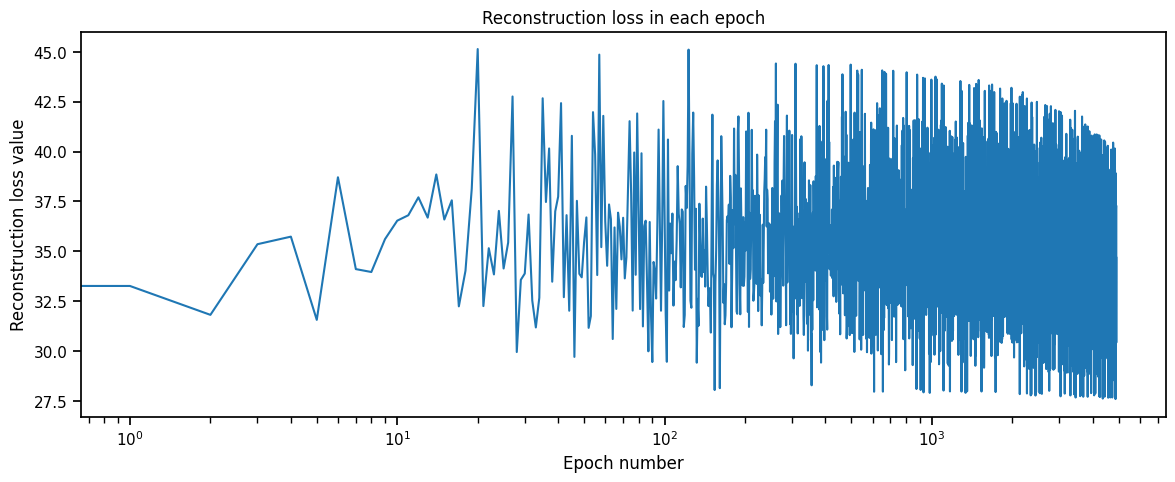

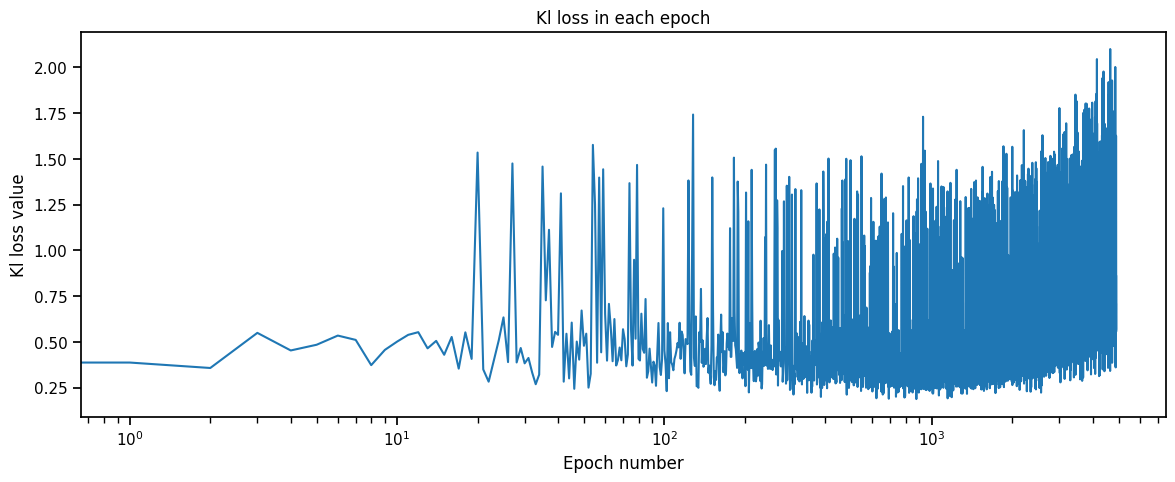

In [113]:
print_loss(total_loss[::10], "Total")
print_loss(reconstruction_loss[::10], "Reconstruction")
print_loss(kl_loss[::10], "Kl")